# Ironhack Final Project

The objective of this competition is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

D_* = Delinquency variables
S_* = Spend variables
P_* = Payment variables
B_* = Balance variables
R_* = Risk variables
with the following features being categorical:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

Your task is to predict, for each customer_ID, the probability of a future payment default (target = 1).

Note that the negative class has been subsampled for this dataset at 5%, and thus receives a 20x weighting in the scoring metric.

Files
train_data.csv - training data with multiple statement dates per customer_ID
train_labels.csv - target label for each customer_ID
test_data.csv - corresponding test data; your objective is to predict the target label for each customer_ID
sample_submission.csv - a sample submission file in the correct format

---

The evaluation metric, 𝑀, for this competition is the mean of two measures of rank ordering: Normalized Gini Coefficient, 𝐺, and default rate captured at 4%, 𝐷.

𝑀=0.5⋅(𝐺+𝐷)

The default rate captured at 4% is the percentage of the positive labels (defaults) captured within the highest-ranked 4% of the predictions, and represents a Sensitivity/Recall statistic.

For both of the sub-metrics 𝐺 and 𝐷, the negative labels are given a weight of 20 to adjust for downsampling.

This metric has a maximum value of 1.0.

Python code for calculating this metric can be found in this Notebook.

# Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import dask.dataframe as dd
import dask.array as da
import dask.bag as db
from dask_ml.decomposition import PCA
from dask_ml.wrappers import Incremental
from dask.dataframe import from_pandas

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import plot_roc_curve

# Reading data

## Train data

In [ ]:
amex_train_data = dd.read_csv('amex-default-prediction/train_data.csv',)

In [3]:
#grouping by customer_ID pela média
amex_train_unique_customers = amex_train_data.groupby(amex_train_data.customer_ID).mean().compute().reset_index()

In [17]:
#sorting by customer_ID
amex_train_unique_customers = amex_train_unique_customers.sort_values(by='customer_ID')

In [26]:
amex_train_unique_customers.to_csv('amex-train-unique-customer.csv',index=False, chunksize=20000)

In [7]:
amex_train_unique_customers = pd.read_csv('amex-train-unique-customer.csv')

## Train Labels

In [9]:
amex_labels = dd.read_csv('amex-default-prediction/train_labels.csv')

In [10]:
#sorting by customer_ID
amex_labels = amex_labels.sort_values(by='customer_ID')

## Test data

In [11]:
amex_test_data = dd.read_csv('amex-default-prediction/test_data.csv')

In [29]:
#grouping by customer_ID pela média
amex_test_unique_customers = amex_test_data.groupby(amex_test_data.customer_ID).mean().compute().reset_index()

In [33]:
#sorting by customer_ID
amex_test_unique_customers = amex_test_unique_customers.sort_values(by='customer_ID')

In [34]:
amex_test_unique_customers.to_csv('amex-test-unique-customer.csv',index=False, chunksize=20000)

In [12]:
amex_test_unique_customers = pd.read_csv('amex-test-unique-customer.csv')

# One batch to use as example

## Treating null values

### Train data

In [13]:
train_null_columns = amex_train_unique_customers.isna().sum() #colunas com valores nulos
train_nulls_above10 = train_null_columns[train_null_columns>(0.1*train_null_columns.max())] #mascara: colunas com mais de 10% dos dados nulos
train_droplist = list(train_nulls_above10.index) #listando colunas com mais de 10% dos dados nulos

In [14]:
amex_null_cleaned = amex_train_unique_customers.drop(columns=train_droplist).dropna().reset_index(drop=True)

### Test data

The same treatment from train data will be applied in test data

In [67]:
test_null_columns = amex_test_unique_customers.isna().sum() #colunas com valores nulos
test_nulls_above10 = test_null_columns[test_null_columns>(0.1*test_null_columns.max())] #mascara: colunas com mais de 10% dos dados nulos
test_droplist = list(test_nulls_above10.index) #listando colunas com mais de 10% dos dados nulos

In [ ]:
amex_test_null_cleaned = amex_test_unique_customers.drop(columns=test_droplist).dropna().reset_index(drop=True)

## Reducing dimensionality with PCA

### Train data

In [32]:
#drop target e seleção das numéricas
X_train = amex_null_cleaned.drop(columns='customer_ID')

In [ ]:
# tentar fazer o modelo sem o fit_partial PCA10 

In [33]:
# redução das variaveis para 10 componentes
from sklearn.decomposition import PCA

pca = PCA(10, svd_solver='randomized', random_state=7)
X_pca = pca.fit_transform(X_train)

In [34]:
print("original shape:   ", X_train.shape)
print("transformed shape:", X_pca.shape)

original shape:    (395239, 150)
transformed shape: (395239, 10)


In [35]:
pca.explained_variance_ratio_

array([0.34703789, 0.28165468, 0.08086514, 0.05085848, 0.04828262,
       0.03557227, 0.02723053, 0.02213108, 0.01146657, 0.00763155])

In [36]:
# com 10 componentes mantemos 91% das informações
pca.explained_variance_ratio_.sum()

0.9127308150138991

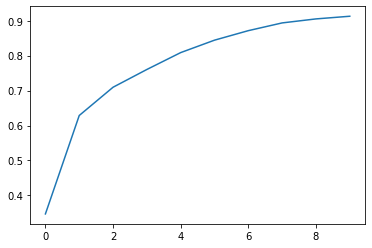

In [37]:
plt.plot(np.cumsum(pca.explained_variance_ratio_),)

In [52]:
# novo df com 15 principal components
pc_columns = [f'pc{i}'for i in range(1,11)]
amex_pca = pd.DataFrame(X_pca, columns=pc_columns)
amex_pca

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,-0.279149,-0.093868,-0.263821,2.097142,-1.013602,-0.631458,0.021451,0.759396,0.378654,-0.535208
1,-0.279644,-0.095974,-0.195206,-1.749018,1.563684,-2.631547,0.147751,1.259314,0.019391,0.689261
2,-0.293562,-0.098206,-0.232702,-1.536221,1.534310,-3.436961,0.118101,0.895366,-0.384437,0.462406
3,-0.280883,-0.094989,-0.249239,1.884923,-0.881231,-0.011842,-0.184552,-1.935728,0.093544,0.311152
4,-0.281148,-0.098376,-0.197430,1.956495,-1.132507,-0.929224,-0.102670,0.623218,-0.339866,-1.179116
...,...,...,...,...,...,...,...,...,...,...
395234,-0.285618,-0.095636,-0.316009,1.814349,-0.460987,-0.567152,0.004019,0.212494,0.319344,0.090424
395235,-0.206421,-0.094287,0.264049,-1.019336,-0.280887,3.349008,-0.292207,2.340251,-0.062114,0.240928
395236,-0.268187,-0.093965,-0.138951,-2.196634,1.670352,-1.773564,0.141575,0.420050,0.289292,-0.209685
395237,-0.256057,-0.096018,0.345846,-1.227044,0.538556,0.087798,-0.179034,-1.306320,-0.126920,-0.497853


In [53]:
amex_categorical = amex_null_cleaned.select_dtypes(exclude='number').sort_values(by='customer_ID').reset_index(drop=True)
amex_categorical

,customer_ID
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...
...,...
395234,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...
395235,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...
395236,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...
395237,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...


In [54]:
amex_train_treated = dd.concat([amex_categorical, amex_pca],axis=1).compute()
amex_train_treated
#salvar no csv

,customer_ID,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,-0.279149,-0.093868,-0.263821,2.097142,-1.013602,-0.631458,0.021451,0.759396,0.378654,-0.535208
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,-0.279644,-0.095974,-0.195206,-1.749018,1.563684,-2.631547,0.147751,1.259314,0.019391,0.689261
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,-0.293562,-0.098206,-0.232702,-1.536221,1.534310,-3.436961,0.118101,0.895366,-0.384437,0.462406
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,-0.280883,-0.094989,-0.249239,1.884923,-0.881231,-0.011842,-0.184552,-1.935728,0.093544,0.311152
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,-0.281148,-0.098376,-0.197430,1.956495,-1.132507,-0.929224,-0.102670,0.623218,-0.339866,-1.179116
...,...,...,...,...,...,...,...,...,...,...,...
395234,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,-0.285618,-0.095636,-0.316009,1.814349,-0.460987,-0.567152,0.004019,0.212494,0.319344,0.090424
395235,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,-0.206421,-0.094287,0.264049,-1.019336,-0.280887,3.349008,-0.292207,2.340251,-0.062114,0.240928
395236,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,-0.268187,-0.093965,-0.138951,-2.196634,1.670352,-1.773564,0.141575,0.420050,0.289292,-0.209685
395237,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,-0.256057,-0.096018,0.345846,-1.227044,0.538556,0.087798,-0.179034,-1.306320,-0.126920,-0.497853


In [55]:
amex_train_treated.to_csv('amex_train_treated.csv',index=False)

In [ ]:
amex_train_treated = pd.read_csv('amex_train_treated.csv')

In [58]:
amex_train_treated

,customer_ID,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,-0.279149,-0.093868,-0.263821,2.097142,-1.013602,-0.631458,0.021451,0.759396,0.378654,-0.535208
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,-0.279644,-0.095974,-0.195206,-1.749018,1.563684,-2.631547,0.147751,1.259314,0.019391,0.689261
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,-0.293562,-0.098206,-0.232702,-1.536221,1.534310,-3.436961,0.118101,0.895366,-0.384437,0.462406
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,-0.280883,-0.094989,-0.249239,1.884923,-0.881231,-0.011842,-0.184552,-1.935728,0.093544,0.311152
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,-0.281148,-0.098376,-0.197430,1.956495,-1.132507,-0.929224,-0.102670,0.623218,-0.339866,-1.179116
...,...,...,...,...,...,...,...,...,...,...,...
395234,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,-0.285618,-0.095636,-0.316009,1.814349,-0.460987,-0.567152,0.004019,0.212494,0.319344,0.090424
395235,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,-0.206421,-0.094287,0.264049,-1.019336,-0.280887,3.349008,-0.292207,2.340251,-0.062114,0.240928
395236,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,-0.268187,-0.093965,-0.138951,-2.196634,1.670352,-1.773564,0.141575,0.420050,0.289292,-0.209685
395237,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,-0.256057,-0.096018,0.345846,-1.227044,0.538556,0.087798,-0.179034,-1.306320,-0.126920,-0.497853


### Test data

In [61]:
#drop do target e seleção das numéricas
X_test = amex_test_null_cleaned[X_train.columns]

In [62]:
# redução das variaveis para 10 componentes
X_test_pca = pca.transform(X_test)

In [63]:
print("original shape:   ", X_test.shape)
print("transformed shape:", X_test_pca.shape)

original shape:    (728799, 150)
transformed shape: (728799, 10)


In [97]:
pca.explained_variance_ratio_

array([0.34703789, 0.28165468, 0.08086514, 0.05085848, 0.04828262,
       0.03557227, 0.02723053, 0.02213108, 0.01146657, 0.00763155])

In [98]:
# com 10 componentes mantemos 99% das informações
pca.explained_variance_ratio_.sum()

0.9127308150138993

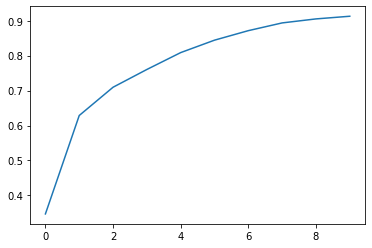

In [99]:
plt.plot(np.cumsum(pca.explained_variance_ratio_),)

In [64]:
# novo df com 10 principal components
pc_columns = [f'pc{i}'for i in range(1,11)]
amex_test_pca = pd.DataFrame(X_test_pca, columns=pc_columns)
amex_test_pca

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,-0.274006,-0.094419,0.197088,-2.179193,1.465991,-2.347746,0.102964,0.610293,-0.131808,0.586444
1,-0.280776,-0.097279,-0.284996,1.195401,-0.424294,-0.872669,-0.042649,0.692132,0.007573,0.645215
2,-0.273543,-0.099396,-0.118071,-1.818800,1.344153,-1.771675,0.034944,0.065945,-0.136435,-0.430860
3,-0.236045,-0.091266,0.209350,1.046538,-1.208037,2.204611,-0.153662,-0.328799,0.109116,-0.442662
4,-0.226910,-0.094527,0.104103,-3.405553,1.600616,0.598934,-0.070109,1.197699,-0.086095,0.900821
...,...,...,...,...,...,...,...,...,...,...
728794,-0.259800,-0.093987,-0.094243,-2.377014,1.535973,-1.373193,0.085899,1.502897,0.036426,0.283996
728795,-0.285362,-0.098095,-0.112884,1.417889,-0.575835,-1.640980,-0.026208,0.701483,-0.253735,0.095161
728796,-0.250645,-0.093743,-0.099897,0.349012,-0.411277,0.620973,-0.157091,0.461936,-0.111307,-0.633838
728797,-0.241607,-0.090805,0.097985,0.399958,-0.562457,0.533393,0.126227,0.930827,-0.241921,-0.431695


In [65]:
amex_test_categorical = amex_test_null_cleaned.select_dtypes(exclude='number').reset_index(drop=True)
amex_test_categorical

,customer_ID
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...
...,...
728794,ffff824b313399b00db6bc930b83f1a2188d8b1dbd3a31...
728795,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...
728796,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...
728797,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...


In [66]:
amex_test_treated = dd.concat([amex_test_categorical, amex_test_pca],axis=1).compute()
amex_test_treated

#salvar no csv

,customer_ID,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,-0.274006,-0.094419,0.197088,-2.179193,1.465991,-2.347746,0.102964,0.610293,-0.131808,0.586444
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,-0.280776,-0.097279,-0.284996,1.195401,-0.424294,-0.872669,-0.042649,0.692132,0.007573,0.645215
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,-0.273543,-0.099396,-0.118071,-1.818800,1.344153,-1.771675,0.034944,0.065945,-0.136435,-0.430860
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,-0.236045,-0.091266,0.209350,1.046538,-1.208037,2.204611,-0.153662,-0.328799,0.109116,-0.442662
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,-0.226910,-0.094527,0.104103,-3.405553,1.600616,0.598934,-0.070109,1.197699,-0.086095,0.900821
...,...,...,...,...,...,...,...,...,...,...,...
728794,ffff824b313399b00db6bc930b83f1a2188d8b1dbd3a31...,-0.259800,-0.093987,-0.094243,-2.377014,1.535973,-1.373193,0.085899,1.502897,0.036426,0.283996
728795,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,-0.285362,-0.098095,-0.112884,1.417889,-0.575835,-1.640980,-0.026208,0.701483,-0.253735,0.095161
728796,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,-0.250645,-0.093743,-0.099897,0.349012,-0.411277,0.620973,-0.157091,0.461936,-0.111307,-0.633838
728797,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,-0.241607,-0.090805,0.097985,0.399958,-0.562457,0.533393,0.126227,0.930827,-0.241921,-0.431695


In [103]:
amex_test_treated.to_csv('amex_test_treated.csv')

In [14]:
amex_test_treated = pd.read_csv('amex_test_treated.csv')

## First baseline modelling

### Appending targets to train data

In [68]:
#merging remaining customer_IDs with target from train values

amex_train_treated_target = dd.merge(left=amex_train_treated, 
                                     right=amex_labels,
                                     left_on='customer_ID',
                                     right_on='customer_ID').compute()
amex_train_treated_target

,customer_ID,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,-0.279149,-0.093868,-0.263821,2.097142,-1.013602,-0.631458,0.021451,0.759396,0.378654,-0.535208,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,-0.279644,-0.095974,-0.195206,-1.749018,1.563684,-2.631547,0.147751,1.259314,0.019391,0.689261,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,-0.293562,-0.098206,-0.232702,-1.536221,1.534310,-3.436961,0.118101,0.895366,-0.384437,0.462406,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,-0.280883,-0.094989,-0.249239,1.884923,-0.881231,-0.011842,-0.184552,-1.935728,0.093544,0.311152,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,-0.281148,-0.098376,-0.197430,1.956495,-1.132507,-0.929224,-0.102670,0.623218,-0.339866,-1.179116,0
...,...,...,...,...,...,...,...,...,...,...,...,...
395234,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,-0.285618,-0.095636,-0.316009,1.814349,-0.460987,-0.567152,0.004019,0.212494,0.319344,0.090424,0
395235,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,-0.206421,-0.094287,0.264049,-1.019336,-0.280887,3.349008,-0.292207,2.340251,-0.062114,0.240928,0
395236,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,-0.268187,-0.093965,-0.138951,-2.196634,1.670352,-1.773564,0.141575,0.420050,0.289292,-0.209685,0
395237,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,-0.256057,-0.096018,0.345846,-1.227044,0.538556,0.087798,-0.179034,-1.306320,-0.126920,-0.497853,1


### Logistic Regression

In [69]:
# Training Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve

X_train=amex_train_treated_target.drop(columns=['customer_ID','target'])
y_train=amex_train_treated_target['target']

lrmodel = LogisticRegression(random_state=7)
lrmodel.fit(X_train,y_train)

LogisticRegression(random_state=7)

In [70]:
# predicting in train database
y_pred = lrmodel.predict(X_train)
y_pred

array([0, 0, 0, ..., 0, 1, 0])

In [71]:
# probabilities to 0 and 1
lrmodel.predict_proba(X_train)

array([[0.97668723, 0.02331277],
       [0.96965344, 0.03034656],
       [0.96404406, 0.03595594],
       ...,
       [0.89535658, 0.10464342],
       [0.49310801, 0.50689199],
       [0.94974499, 0.05025501]])

In [72]:
lrmodel.coef_

array([[ 0.03953192,  0.00584185,  0.36657398, -0.51247883,  0.06474141,
         0.72576895,  0.17072155, -0.23082317, -1.57750852, -0.74599837]])

In [73]:
lrmodel.intercept_

array([-1.65852591])

In [74]:
lrmodel.score(X_train,y_train)

0.8247946179400312

<AxesSubplot:>

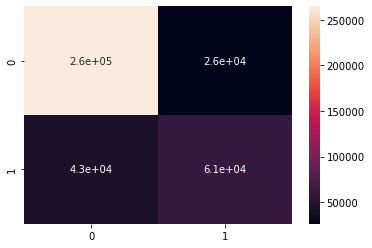

In [79]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_train,y_pred)
sns.heatmap(matrix, annot=True)


In [80]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

recall_score(y_train,y_pred) , precision_score(y_train,y_pred)

(0.5867017345146335, 0.7000332138398635)

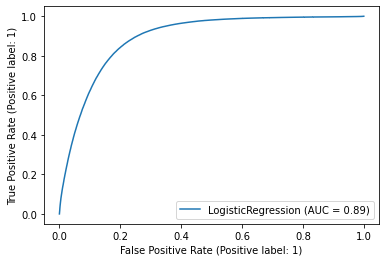

In [124]:
plot_roc_curve(lrmodel, X_train, y_train)

### Predicting with test data

In [82]:
# selecting numeric features from test pca base
X_test = amex_test_treated.select_dtypes('number')

In [83]:
# running the model with test data
y_pred = lrmodel.predict(X_test)

In [84]:
amex_test_treated['y_pred'] = y_pred

In [85]:
lrmodel.coef_

array([[ 0.03953192,  0.00584185,  0.36657398, -0.51247883,  0.06474141,
         0.72576895,  0.17072155, -0.23082317, -1.57750852, -0.74599837]])

In [86]:
lrmodel.intercept_

array([-1.65852591])

In [87]:
# probabilities to 0 and 1
lrmodel.predict_proba(X_test)

array([[0.9200283 , 0.0799717 ],
       [0.97607057, 0.02392943],
       [0.81038574, 0.18961426],
       ...,
       [0.72019331, 0.27980669],
       [0.72642977, 0.27357023],
       [0.40929223, 0.59070777]])

In [88]:
amex_test_treated.head()

,customer_ID,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,y_pred
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,-0.274,-0.094,0.197,-2.179,1.466,-2.348,0.103,0.610,-0.132,0.586,0
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,-0.281,-0.097,-0.285,1.195,-0.424,-0.873,-0.043,0.692,0.008,0.645,0
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,-0.274,-0.099,-0.118,-1.819,1.344,-1.772,0.035,0.066,-0.136,-0.431,0
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,-0.236,-0.091,0.209,1.047,-1.208,2.205,-0.154,-0.329,0.109,-0.443,0
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,-0.227,-0.095,0.104,-3.406,1.601,0.599,-0.070,1.198,-0.086,0.901,0


# New treatments

Rescueing code from Treating null values

## Filling nulls with columns average

### Train data

In [87]:
# train base = unique customers without columns 10% above null values colunms
new_train = amex_train_unique_customers.drop(columns=train_droplist)
new_train.shape

(458913, 151)

In [88]:
new_train = dd.merge(left=new_train, 
        right=amex_labels,
        left_on='customer_ID',
        right_on='customer_ID').compute()

In [89]:
new_train.shape

(458913, 152)

In [90]:
new_train_treated = new_train.fillna(new_train.select_dtypes('number').mean())

In [91]:
new_train_treated.to_csv('new_train_treated.csv',index=False)

### Test data

In [97]:
# test base = unique customers without columns 10% above null values colunms
new_test = amex_test_unique_customers[new_train.columns.drop('target')]

In [98]:
new_test.shape

(924621, 151)

In [99]:
new_test_treated = new_test.fillna(new_test.select_dtypes('number').mean())

In [100]:
new_test_treated.to_csv('new_test_treated.csv',index=False)

In [ ]:
#dropar as colunas >0.1 e fillar com media

See results in Pycaret document

Pycaret - LGBM was the best one.

Competition score = 0.75

## KNN Imputer

### Train data

proximos passos: Tentar KNN, ou deixar para o futuro
KNN Imputer (pode demorar)
Interative Imputer

In [ ]:
from sklearn.impute import KNNImputer

X=amex_train_unique_customers.select_dtypes('number')

knn = KNNImputer(n_neighbors=3)
knn.fit_transform(X)

In [ ]:
from sklearn.impute import KNNImputer

X=amex_test_unique_customers.select_dtypes('number')

knn = KNNImputer(n_neighbors=5)
knn.fit_transform(X)